# <a id="index">Index</a>
## [0. Setup](#setup)
## [0.1 Paths](#paths)
## [1. Dataset Classes](#datasetClasses)
## [2. Model Classes](#modelClasses)
## [3. Train Function](#trainFunction)
## [4. Test Function](#testFunction)
## [5. Checkpoint Classes](#checkpointClasses)
## [6. Train](#train)

# <a id="setup">0. Setup</a>
[Back To Index](#index)

In [106]:
import torch
from utils import *
import numpy as np
from pathlib import Path
import torch.utils.data as data_utils
from torch.utils.data import DataLoader, Dataset
import torchvision
import torch.nn as nn
from torchvision import transforms
import os
import glob
import os.path as osp
import matplotlib.pyplot as plt
%matplotlib inline


import torch.nn as nn            # containing various building blocks for your neural networks
import torch.optim as optim      # implementing various optimization algorithms
import torch.nn.functional as F  # a lower level (compared to torch.nn) interface

# torchvision: popular datasets, model architectures, and common image transformations for computer vision.
import torchvision
# transforms: transformations useful for image processing
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader

import glob
import os.path as osp
import numpy as np
from PIL import Image


import torch
import torchvision
import torch.nn as nn
import numpy as np
from pathlib import Path
import torch.utils.data as data_utils
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.models as models
import torchvision
from torchvision import transforms
import pandas as pd
from skimage import io, transform
import os
import h5py
import glob
import os.path as osp
import time
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F
from torch.autograd import Variable
from PIL import Image
from numpy import genfromtxt
%matplotlib inline

In [107]:
#Paths
path_to_data='../project_data/'
path_to_data_images_train=path_to_data+'Mamm_Images_Train'
path_to_data_images_eval=path_to_data+'Mamm_Images_Eval'
path_to_data_images_test=path_to_data+'Mamm_Images_Test'
path_to_models='../models/'

In [108]:
# Use GPU if available, otherwise stick with cpu
use_cuda = torch.cuda.is_available()
torch.manual_seed(123)
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
print_every = 25

cuda


# <a id="datasetClasses">1. Dataset Classes</a>
[Back To Index](#index)

In [109]:
class MammogramDataset(Dataset):
    def __init__(self,csv_file,root_dir):
        self.labels = genfromtxt(csv_file).astype(int)
        self.root_dir = root_dir
        self.transform=transforms.ToTensor()
    def __len__(self):
        return len(self.labels)
    def __getitem__(self,ind):
        img_path=os.path.join(self.root_dir,'image'+str(ind)+'.jpg')
        img=Image.open(img_path)
        img=self.transform(img).type(torch.float32)
        label=self.labels[ind]
        return Variable(img),label

In [110]:
def resize2d(img, size):
    return (F.adaptive_avg_pool2d(Variable(img,volatile=True), size)).data

In [111]:
#Load
mam_train=MammogramDataset(path_to_data+'train_complex_labels.csv',path_to_data_images_train)
mam_valid=MammogramDataset(path_to_data+'eval_complex_labels.csv', path_to_data_images_eval)
mam_test=MammogramDataset (path_to_data+'eval_complex_labels.csv', path_to_data_images_test)

label: 0
torch.Size([1, 299, 299])


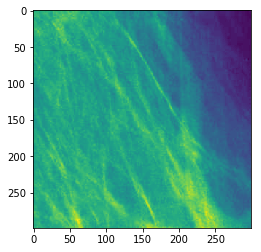

In [112]:
#Check
datapoint=mam_train[0]
image=datapoint[0]
label=datapoint[1]
print("label:", label)
print(image.size())
plt.imshow(image[0])

In [113]:
#DataLoaders
train_loader =      data_utils.DataLoader(mam_train, batch_size=32, shuffle=True)
validation_loader = data_utils.DataLoader(mam_valid, batch_size=32, shuffle=True)
test_loader =       data_utils.DataLoader(mam_test, batch_size=32, shuffle=True)

# <a id="modelClasses">2. Model Classes</a>
[Back To Index](#index)

In [114]:
def check_accuracy(loader, model,status='test'):
    
    if status=='valid':
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')
    
    num_correct = {'All':0,'0':0,'1':0,'2':0,'3':0,'4':0}
    num_samples = {'All':0,'0':0,'1':0,'2':0,'3':0,'4':0}
    acc =         {'All':0,'0':0,'1':0,'2':0,'3':0,'4':0} 
    
    model.eval() # set model to evaluation mode
    
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=torch.float32) # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            
            
            num_correct['All'] += (preds == y).sum()
            t4=time.time()
            num_samples['All'] += preds.size(0)
            
            for i in range(5):
                num_correct[str(i)]+=((preds == i)*(preds == y)).sum()
                num_samples[str(i)]+= (y==i).sum()
    
        
        
        for k in num_correct.keys():
            acc[k] = float(num_correct[k]) / float(num_samples[k])
            print('Got %d / %d correct (%.2f) in class: ' % (num_correct[k], num_samples[k], 100 * acc[k]),k)

# <a id="checkpointClasses">5. Checkpoint Classes</a>
[Back To Index](#index)

In [115]:
def save_checkpoint(checkpoint_path, model, optimizer, epoch):
    # state_dict: a Python dictionary object that:
    # - for a model, maps each layer to its parameter tensor;
    # - for an optimizer, contains info about the optimizer’s states and hyperparameters used.
    state = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer' : optimizer.state_dict()
    }
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)

    
def load_checkpoint(checkpoint_path, model, optimizer):
    
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    epoch = state['epoch']
    print('model loaded from %s' % checkpoint_path)
    return epoch
 

def get_last_checkpoint(path_to_models, model_type):
    
    last_version=0
    
    for f_name in os.listdir(path_to_models):

        if f_name.endswith('.pth') and f_name.startswith('mamo'+'-'+model_type):
            version=int(f_name.split('.pth')[0].split('-')[2])

            if version>last_version:
                last_version=version
    
    checkpoint_name=None
    
    if last_version>0:
        checkpoint_name='mamo'+'-'+model_type+'-'+str(last_version)+'.pth'           
    
    return checkpoint_name

In [116]:
!ls ../models/

mamo-resnet18-0.pth   mamo-resnet18-16.pth  mamo-resnet18-5.pth
mamo-resnet18-10.pth  mamo-resnet18-17.pth  mamo-resnet18-6.pth
mamo-resnet18-11.pth  mamo-resnet18-18.pth  mamo-resnet18-7.pth
mamo-resnet18-12.pth  mamo-resnet18-1.pth   mamo-resnet18-8.pth
mamo-resnet18-13.pth  mamo-resnet18-2.pth   mamo-resnet18-9.pth
mamo-resnet18-14.pth  mamo-resnet18-3.pth
mamo-resnet18-15.pth  mamo-resnet18-4.pth


# <a id="trainFunction">3. Train Function</a>
[Back To Index](#index)

In [121]:
def train_data(model, model_type, optimizer, epochs=1, accuracy_interval=100, save_interval=100, last_epoch=0):
    
    """Train a model on data using the PyTorch Module API (taken from HW2).
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    Returns: Nothing, but prints model accuracies during training."""
    
    model = model.to(device=device) # move the model parameters to CPU/GPU
    labels_counts=np.unique(mam_train.labels, return_counts=True)
    counts=labels_counts[1]
    weights=torch.from_numpy(np.reciprocal(counts.astype(np.float64))).to(device=device,dtype=torch.float32)
    
    for e in range(1,epochs):
        model.train() # put model to training mode
        
        for t,(x,y) in enumerate(train_loader):
            x = x.to(device=device, dtype=torch.float32) # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            
            normal_loss=True
            if normal_loss:           
                loss_fcn=torch.nn.CrossEntropyLoss(weight=weights)
                loss=loss_fcn(scores,y)
            else:
                loss_fcn=Roc_Auc_Loss()
                labels=torch.nn.functional.one_hot(y)
                prob_weights=torch.ones_like(labels)
                loss=loss_fcn(labels=labels, logits=scores, prob_weights=prob_weights)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()
            
            # This is the backwards pass: compute the gradient of the loss with
            # respect to each parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

                       
            if t % accuracy_interval == 0:
                print("Iteration: ", t, " Epoch: ",  last_epoch+e)
                print('Iteration %d, loss = %.4f' % (t, loss.item())) 
                check_accuracy(validation_loader, model,'valid')
                print()
                
                
            if t % save_interval == 0 and t > 0:
                last_checkpoint='mamo'+'-'+ model_type+'-'+'%i.pth' % (e+last_epoch)
                
                save_checkpoint(path_to_models+last_checkpoint, model, optimizer, e+last_epoch)
            
    
    # save the final model
    last_checkpoint='mamo'+'-'+ model_type+'-'+'%i.pth' % (e+last_epoch)
                
    save_checkpoint(path_to_models+last_checkpoint, model, optimizer, e+last_epoch)

In [125]:
# Model Parameters

model = models.resnet18(pretrained=False)
model.conv1=torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc=torch.nn.Linear(in_features=512, out_features=5, bias=True)
dtype=torch.cuda.FloatTensor
model.type(dtype)



#Optimizer Parameters

lr=1e-3
optimizer=torch.optim.Adam(model.parameters(),lr)
epochs=40

#Load Last Checkpoint:
model_type='resnet18'

last_checkpoint=None
last_epoch=0
last_checkpoint=get_last_checkpoint(path_to_models, model_type)

if last_checkpoint is not None:
    print("loading:", last_checkpoint)
    last_epoch=load_checkpoint(path_to_models+last_checkpoint, model, optimizer)


#Train Parameters

accuracy_interval=100 
save_interval=100



loading: mamo-resnet18-27.pth
model loaded from ../models/mamo-resnet18-27.pth


In [126]:
model.__class__.__name__
model.__class__.__dict__

mappingproxy({'__module__': 'torchvision.models.resnet',
              '__init__': <function torchvision.models.resnet.ResNet.__init__(self, block, layers, num_classes=1000, zero_init_residual=False)>,
              '_make_layer': <function torchvision.models.resnet.ResNet._make_layer(self, block, planes, blocks, stride=1)>,
              'forward': <function torchvision.models.resnet.ResNet.forward(self, x)>,
              '__doc__': None})

# <a id="trainLoop">6. Train</a>
[Back To Index](#index)

In [127]:
print("training now")
train_data(model\
           ,model_type\
           ,optimizer\
           ,epochs\
           ,accuracy_interval\
           ,save_interval\
           ,last_epoch\
          )

training now
Iteration:  0  Epoch:  28
Iteration 0, loss = 1.5356
Checking accuracy on validation set
Got 285 / 500 correct (57.00) in class:  All
Got 198 / 250 correct (79.20) in class:  0
Got 32 / 70 correct (45.71) in class:  1
Got 23 / 77 correct (29.87) in class:  2
Got 13 / 40 correct (32.50) in class:  3
Got 19 / 63 correct (30.16) in class:  4

Iteration:  100  Epoch:  28
Iteration 100, loss = 1.0942
Checking accuracy on validation set
Got 292 / 500 correct (58.40) in class:  All
Got 205 / 250 correct (82.00) in class:  0
Got 42 / 70 correct (60.00) in class:  1
Got 18 / 77 correct (23.38) in class:  2
Got 5 / 40 correct (12.50) in class:  3
Got 22 / 63 correct (34.92) in class:  4

model saved to ../models/mamo-resnet18-28.pth
Iteration:  0  Epoch:  29
Iteration 0, loss = 2.0367
Checking accuracy on validation set
Got 292 / 500 correct (58.40) in class:  All
Got 185 / 250 correct (74.00) in class:  0
Got 42 / 70 correct (60.00) in class:  1
Got 28 / 77 correct (36.36) in class

Iteration:  100  Epoch:  39
Iteration 100, loss = 1.0396
Checking accuracy on validation set
Got 282 / 500 correct (56.40) in class:  All
Got 185 / 250 correct (74.00) in class:  0
Got 35 / 70 correct (50.00) in class:  1
Got 43 / 77 correct (55.84) in class:  2
Got 9 / 40 correct (22.50) in class:  3
Got 10 / 63 correct (15.87) in class:  4

model saved to ../models/mamo-resnet18-39.pth
Iteration:  0  Epoch:  40
Iteration 0, loss = 1.8853
Checking accuracy on validation set
Got 257 / 500 correct (51.40) in class:  All
Got 165 / 250 correct (66.00) in class:  0
Got 41 / 70 correct (58.57) in class:  1
Got 17 / 77 correct (22.08) in class:  2
Got 9 / 40 correct (22.50) in class:  3
Got 25 / 63 correct (39.68) in class:  4

Iteration:  100  Epoch:  40
Iteration 100, loss = 1.4521
Checking accuracy on validation set
Got 303 / 500 correct (60.60) in class:  All
Got 210 / 250 correct (84.00) in class:  0
Got 37 / 70 correct (52.86) in class:  1
Got 25 / 77 correct (32.47) in class:  2
Got 5

Iteration:  0  Epoch:  51
Iteration 0, loss = 2.3975
Checking accuracy on validation set
Got 302 / 500 correct (60.40) in class:  All
Got 207 / 250 correct (82.80) in class:  0
Got 38 / 70 correct (54.29) in class:  1
Got 38 / 77 correct (49.35) in class:  2
Got 4 / 40 correct (10.00) in class:  3
Got 15 / 63 correct (23.81) in class:  4

Iteration:  100  Epoch:  51
Iteration 100, loss = 0.9106
Checking accuracy on validation set
Got 275 / 500 correct (55.00) in class:  All
Got 174 / 250 correct (69.60) in class:  0
Got 16 / 70 correct (22.86) in class:  1
Got 30 / 77 correct (38.96) in class:  2
Got 22 / 40 correct (55.00) in class:  3
Got 33 / 63 correct (52.38) in class:  4

model saved to ../models/mamo-resnet18-51.pth
Iteration:  0  Epoch:  52
Iteration 0, loss = 2.1717
Checking accuracy on validation set
Got 290 / 500 correct (58.00) in class:  All
Got 220 / 250 correct (88.00) in class:  0
Got 22 / 70 correct (31.43) in class:  1
Got 27 / 77 correct (35.06) in class:  2
Got 9 / 

Iteration:  100  Epoch:  62
Iteration 100, loss = 0.6256
Checking accuracy on validation set
Got 271 / 500 correct (54.20) in class:  All
Got 187 / 250 correct (74.80) in class:  0
Got 18 / 70 correct (25.71) in class:  1
Got 14 / 77 correct (18.18) in class:  2
Got 25 / 40 correct (62.50) in class:  3
Got 27 / 63 correct (42.86) in class:  4

model saved to ../models/mamo-resnet18-62.pth
Iteration:  0  Epoch:  63
Iteration 0, loss = 3.2322
Checking accuracy on validation set
Got 289 / 500 correct (57.80) in class:  All
Got 225 / 250 correct (90.00) in class:  0
Got 27 / 70 correct (38.57) in class:  1
Got 12 / 77 correct (15.58) in class:  2
Got 8 / 40 correct (20.00) in class:  3
Got 17 / 63 correct (26.98) in class:  4

Iteration:  100  Epoch:  63
Iteration 100, loss = 0.7424
Checking accuracy on validation set
Got 281 / 500 correct (56.20) in class:  All
Got 184 / 250 correct (73.60) in class:  0
Got 31 / 70 correct (44.29) in class:  1
Got 26 / 77 correct (33.77) in class:  2
Got 